

# Decoding (MVPA)

This notebook demonstrates the classification of two trial categories over time in sensor and source space, including temporal generalization and the visualization of classifier patterns.


In [1]:
# This notebook is based on MNE-Python tutorials and examples, e.g.
# https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html
# https://mne.tools/stable/auto_examples/decoding/linear_model_patterns.html
# https://mne.tools/stable/auto_examples/decoding/decoding_spatio_temporal_source.html

# Modified by Olaf Hauk, olaf.hauk@mrc-cbu.cam.ac.uk
# These notebooks complement the online lectures "Introduction to EEG/MEG analysis":
# https://www.youtube.com/playlist?list=PLp67eqWCj2f_DBsCMkIOBpBbLWGAUKtu5

Decoding (traditionally called Multi-Voxel Pattern Analysis, or MVPA) in MNE is mostly based on the scikit-learn package. For more details visit scikit-learn_.

We will demonstrate the basic approach with a simple two-class classification problem, i.e. whether we can distinguish auditory from visual events based on their EEG/MEG signal patterns.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import mne
from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

data_path = sample.data_path()

subjects_dir = data_path / "subjects"
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"
tmin, tmax = -0.200, 0.500
event_id = {"Auditory/Left": 1, "Visual/Left": 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname)
raw.pick(picks=['eeg', 'meg', "stim", "eog"])
# Note: When using multiple channel types one has to use appropriate scaling

# The subsequent decoding analyses only capture evoked responses, so we can
# low-pass the MEG data. Usually a value more like 40 Hz would be used,
# and some authors prefer not to filter their data at all for decoding analyses.
# Here, we low-pass at 20 so we can more heavily decimate, and allow
# the example to run faster.
raw.load_data().filter(0, 20)
events = mne.find_events(raw, "STI 014")

# Set up bad channels (modify to your needs)
raw.info["bads"] += ["MEG 2443"]  # bads + 2 more

# channel type(s) used for decoding
ch_type = ['grad']

# reject criteria according to channel type(s)
# reject = dict(mag=4000e-15, grad=4000e-13, eeg=150e-6, eog=250e-6)
reject = dict(grad=4000e-13, eog=250e-6)

# Create epochs
epochs_ori = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    baseline=(None, 0.0),
    preload=True,
    reject=reject,
    decim=3,  # decimate to reduce computation time (note low-pass filter above)
    verbose="error",
)

epochs = epochs_ori.copy().pick(picks=ch_type, exclude="bads")  # remove stim and EOG

# We have to specify the data to be used for decoding (X) and 
# provide labels (y) to distinguish the two stimulus classes we want to decode.
data = epochs.get_data(copy=False)  # EEG/MEG signals: n_epochs, n_meg_channels, n_times
X = data.copy()  # we may want to change X and y later but keep the original data
labels = epochs.events[:, 2]  # labels (e.g. auditory left vs visual left)
y = labels.copy()

Opening raw data file C:\Users\olaf\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 101 samples (0.673 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s


## Decoding over time

This strategy consists in fitting a multivariate predictive model on each
time instant and evaluating its performance at the same instant on new
epochs. The :class:`mne.decoding.SlidingEstimator` will take as input a
pair of features $X$ and targets $y$, where $X$ has
more than 2 dimensions. For decoding over time the data $X$
is the epochs data of shape n_epochs × n_channels × n_times. As the
last dimension of $X$ is the time, an estimator will be fit
on every time instant.

We'll use a Logistic Regression for a binary classification as machine
learning model.



In [26]:
# # The example uses sample-by-sample decoding. You may want to decode the pattern combined
# # across a latency window around each sample, either by stacking the patterns or by taking
# # their means. This requires a function like the following.
# # Thanks to Mate Aller: https://github.com/MRC-CBU/COGNESTIC/blob/main/10_MVPA_EEG_MEG/mvpa.py.

# def windowizer(
#     X,
#     window_size=10,
#     win_func='expand_features'
# ):
#     """Windowizer function to create a sliding window of size window_size
#     over the last dimension of the input data X.
    
#     Parameters
#     ----------
#     X : np.ndarray
#         Input data of shape (n_examples, n_features, n_timepoints)
#     window_size : int
#         Size of the sliding window in timepoints.
#     win_func : str
#         Function to apply to the windowed data. Options are 'expand_features' or 'mean'.
#         - 'expand_features' reshapes the data within each window to yield a 
#             n_features*window_size array. This is performed in a moving window 
#             fashion for each timepoint (so that there is window_size-1) overlap 
#             between windows. This is computed separately for each example, so 
#             the output shape is 
#             (n_examples, n_features*window_size, n_timepoints-window_size+1)
#         - 'mean'computes the moving average of the data across the timepoints 
#             separately for each example. The output shape is 
#             (n_examples, n_features, n_timepoints-window_size)
#     """

#     assert win_func in ['expand_features', 'mean']
    
#     X_win = []
#     for i in range(0, X.shape[-1]-window_size+1):
#         temp = X[:, :, i:i+window_size]
#         if win_func == 'expand_features':
#             temp = np.reshape(temp, (temp.shape[0], -1))
#         elif win_func == 'mean':
#             temp = np.mean(temp, axis=-1)
#         X_win.append(np.expand_dims(temp, axis=-1))
#     X_win = np.concatenate(X_win, axis=-1)

#     return X_win

# X = windowizer(data, 2, 'expand_features')

# # Note what happened:
# print(data.shape)
# print(X.shape)

In [27]:
# # You may also want to create "pseudotrials", i.e. average across small batches of epochs before decoding.
# # Thanks to Mate Aller: https://github.com/MRC-CBU/COGNESTIC/blob/main/10_MVPA_EEG_MEG/mvpa.py.

# def pseudotrial_generator(
#     X,
#     y,
#     n_trials_to_average=8
# ):
#     """Function to average the examples of each condition in X and y into
#     evoked responses based on the number of examples to average.
    
#     Parameters
#     ----------
#         X : np.ndarray
#             Input data of shape (n_examples, n_features, n_timepoints)
#         y : np.ndarray
#             Labels of the input data of shape (n_examples)
#         n_trials_to_average : int
#             Number of examples to average from the same condition to create the 
#             evoked response.
#     Returns
#     -------
#         X_avg : np.ndarray
#             Averaged data of shape (n_evoked, n_features, n_timepoints)
#         y_avg : np.ndarray
#             Labels of the averaged data of shape (n_evoked)
#     """
#     labels, label_ind = np.unique(y, return_inverse=True)
#     X_avg = []
#     y_avg = []
#     # Loop around conditions (labels)
#     for i in range(len(labels)):
#         # select indices of the current condition and shuffle them
#         temp = np.squeeze(np.argwhere(label_ind == i))
#         np.random.shuffle(temp)
#         # compute the number of examples after averaging given the number of examples to average
#         n_avg_examples = int(np.ceil(len(temp)/n_trials_to_average))
#         # select the indices of the examples to average
#         # create index for averaging based on the modulo of the number of averaged examples
#         temp_ind = np.array([j%n_avg_examples for j in range(0, len(temp))])
#         avg_ind = [temp[np.squeeze(np.argwhere(temp_ind == j))] for j in range(n_avg_examples)]
#         # Average the examples based on the computed indices
#         for ind in avg_ind:
#             X_avg.append(np.mean(X[ind], axis=0, keepdims=True))
#             y_avg.append(labels[i])
#     X_avg = np.concatenate(X_avg, axis=0)
#     y_avg = np.array(y_avg)
#     return X_avg, y_avg

# X, y = pseudotrial_generator(data, labels, 4)

# # Check what happened:
# print(labels.shape)
# print(y.shape)

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

Text(0.5, 1.0, 'Sensor space decoding')

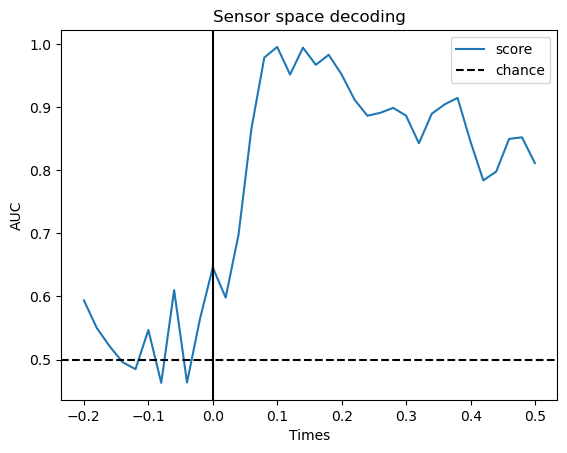

In [2]:
from sklearn.linear_model import LogisticRegression as my_classifier
clf = make_pipeline(StandardScaler(), my_classifier(solver="liblinear"))

# You can use other methods from sklearn, but you may have to check their parameters.
# Examples: linear_model.RidgeClassifier, Support Vector Machines: svm.SVC

# Set up models to each subset of the dataset along the last dimension (here: timepoint by timepoint).
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)
# Score the classifier using cross-validation.
# Here we use only cv=3 for speed.
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits, per timepoint
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
n_times = X.shape[-1]
ax.plot(epochs.times[:n_times], scores, label="score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

You can retrieve the spatial filters and spatial patterns if you explicitly
use a LinearModel, and treat them as Evoked objects:



  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


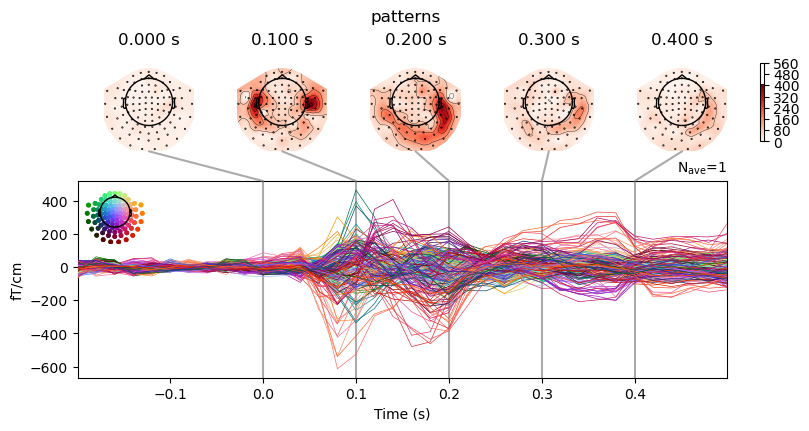

In [3]:
clf = make_pipeline(
    StandardScaler(), LinearModel(LogisticRegression(solver="liblinear"))
)
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, "patterns_", inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s"))
evoked_time_gen.plot_joint(
    times=np.arange(0.0, 0.500, 0.100), title="patterns", **joint_kwargs
);

### Temporal generalization

Temporal generalization is an extension of the decoding over time approach.
It consists in evaluating whether the model estimated at a particular
time instant accurately predicts any other time instant. It is analogous to
transferring a trained model to a distinct learning problem, where the
problems correspond to decoding the patterns of brain activity recorded at
distinct time instants.

The object to for Temporal generalization is
:class:`mne.decoding.GeneralizingEstimator`. It expects as input $X$
and $y$ (similarly to :class:`~mne.decoding.SlidingEstimator`) but
generates predictions from each model for all time instants. The class
:class:`~mne.decoding.GeneralizingEstimator` is generic and will treat the
last dimension as the one to be used for generalization testing. For
convenience, here, we refer to it as different tasks. If $X$
corresponds to epochs data then the last dimension is time.

This runs the analysis used in :footcite:`KingEtAl2014` and further detailed
in :footcite:`KingDehaene2014`:



  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

Text(0.5, 1.0, 'Decoding MEG sensors over time')

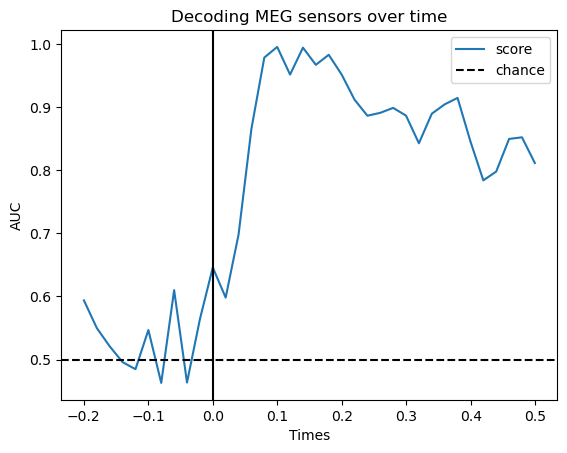

In [4]:
# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# again, cv=3 just for speed
scores = cross_val_multiscore(time_gen, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label="score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlabel("Times")
ax.set_ylabel("AUC")
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Decoding MEG sensors over time")

Plot the full (generalization) matrix:



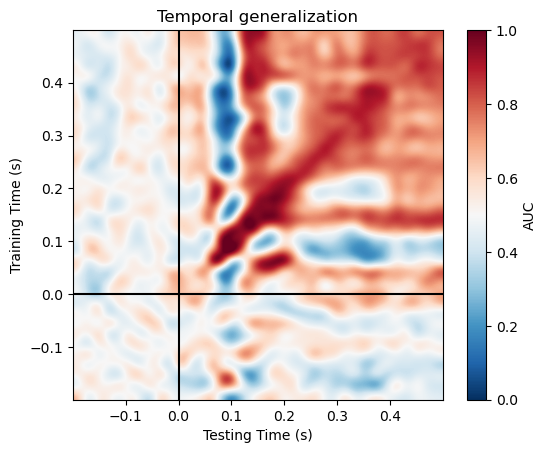

In [5]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(
    scores,
    interpolation="lanczos",
    origin="lower",
    cmap="RdBu_r",
    extent=epochs.times[[0, -1, 0, -1]],
    vmin=0.0,
    vmax=1.0,
)
ax.set_xlabel("Testing Time (s)")
ax.set_ylabel("Training Time (s)")
ax.set_title("Temporal generalization")
ax.axvline(0, color="k")
ax.axhline(0, color="k")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("AUC")

## Projecting sensor-space patterns to source space
If you use a linear classifier (or regressor) for your data, you can also
project these to source space. For example, using our ``evoked_time_gen``
from before:



In [6]:
cov = mne.compute_covariance(epochs, tmax=0.0)
del epochs
fwd = mne.read_forward_solution(meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif")
inv = mne.minimum_norm.make_inverse_operator(evoked_time_gen.info, fwd, cov, loose=0.0)
stc = mne.minimum_norm.apply_inverse(evoked_time_gen, inv, 1.0 / 9.0, "dSPM")
del fwd, inv

Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 1562
[done]
Reading forward solution from C:\Users\olaf\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame
Computing inverse ope

And this can be visualized using :meth:`stc.plot <mne.SourceEstimate.plot>`:



In [7]:
maxval = np.abs(stc.data).max()
brain = stc.plot(
    hemi="split", views=("lat", "med"), initial_time=0.1, subjects_dir=subjects_dir, clim={'kind': 'value', 'lims': [0, maxval/2, maxval]}
)

Using pyvistaqt 3d backend.
False


## Source-space decoding

Source space decoding is also possible, but because the number of features
can be much larger than in the sensor space, univariate feature selection
using ANOVA f-test (or some other metric) can be done to reduce the feature
dimension. Interpreting decoding results might be easier in source space as
compared to sensor space.

.. topic:: Examples

    * `ex-dec-st-source`

In [8]:
fname_cov = meg_path / "sample_audvis-cov.fif"
fname_inv = meg_path / "sample_audvis-meg-oct-6-meg-inv.fif"

snr = 3.0
noise_cov = mne.read_cov(fname_cov)
inverse_operator = mne.minimum_norm.read_inverse_operator(fname_inv)

stcs = mne.minimum_norm.apply_inverse_epochs(
    epochs_ori,
    inverse_operator,
    lambda2=1.0 / snr**2,
    verbose=False,
    method="dSPM",
    pick_ori="normal",  # keeps the sign of activations
)

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading inverse operator decomposition from C:\Users\olaf\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not f

Just quickly check that we kept the sign of activations - this provides more information for decoding.

In [9]:
print("Min|Max: %f|%f." % (stcs[0].data.min(), stcs[0].data.max())) 

Min|Max: -7.554996|7.428741.


  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

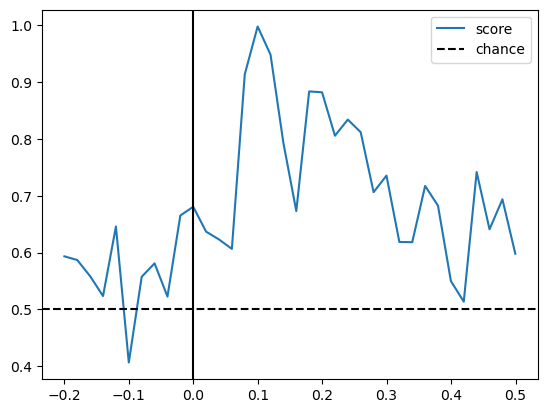

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif

# Retrieve source space data into an array, here only for left hemisphere
X = np.array([stc.lh_data for stc in stcs])  # only keep left hemisphere
y = epochs_ori.events[:, 2]

# prepare a series of classifier applied at each time sample
clf = make_pipeline(
    StandardScaler(),  # z-score normalization
    SelectKBest(f_classif, k=500),  # select features for speed
    LinearModel(LogisticRegression(C=1, solver="liblinear")),
)
time_decod = SlidingEstimator(clf, scoring="roc_auc")

# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(epochs_ori.times, scores.mean(0), label="score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.axvline(0, color="k")
plt.legend()

We may want to decode from separate labels in source space:

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

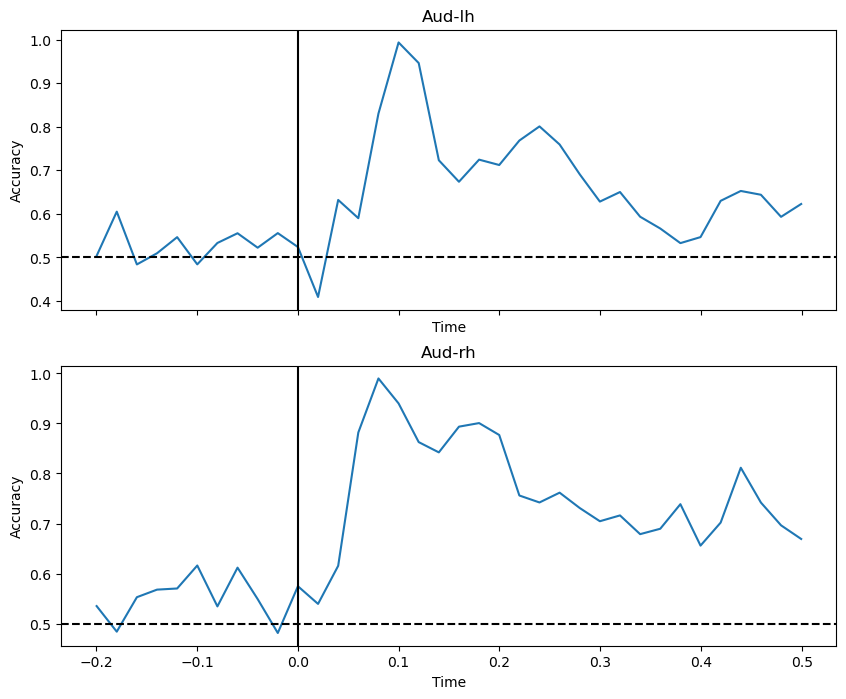

In [11]:
label_names = ["Aud-lh", "Aud-rh"]
fname_labels = [meg_path / "labels" / f"{ln}.label" for ln in label_names]
labels = [mne.read_label(fl) for fl in fname_labels]

# for a label, we don't have to select best features
clf = make_pipeline(
    StandardScaler(),  # z-score normalization
    LinearModel(LogisticRegression(C=1, solver="liblinear")),
)
time_decod = SlidingEstimator(clf, scoring="roc_auc")

y = epochs_ori.events[:, 2]
scores = {}
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
for [label, ax] in zip(labels, axes):
    stcs_label = [stc.in_label(label) for stc in stcs]

    X = np.array([stc.data for stc in stcs_label])  # only keep left hemisphere

    scores[label.name] = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

    ax.plot(stcs[0].times, scores[label.name].mean(0), label="score")
    ax.axhline(0.5, color="k", linestyle="--", label="chance")
    ax.axvline(0, color="k")
    ax.set(title=label.name, xlabel="Time", ylabel="Accuracy")


Note: Due to the smoothness (low spatial resolution) of EEG/MEG data, the patterns in labels usually have much lower dimensionality than the number of vertices suggests. We can illustrate this by looking at the singular values of the data within one label.

As always, be aware of the limited spatial resolution of EEG/MEG source estimation. Remember that PSFs/CTFs may help you with interpretation and decision making.

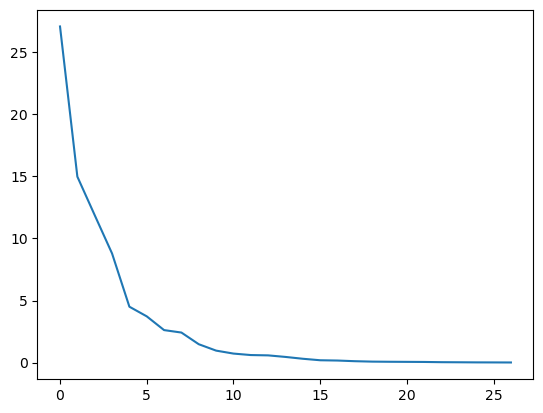

In [12]:
s = np.linalg.svd(stcs_label[0].data, compute_uv=False)
plt.plot(s)

We could use the functions above to analyze latency windows and to compute pseudotrials.